In [3]:
%load_ext autoreload
%autoreload 2

# Imports and Setup

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import scipy
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pandas as pd
from scipy.stats import gaussian_kde
# import seaborn as sns # v 0.11.0
import os
import h5py
import numpy as np
from astropy import units as u, constants as const
from scipy.interpolate import interp1d
import healpy as hp

In [2]:
###### # Setup Plotting Defaults #
###################################### ##
# For more options see https://matplotlib.org/users/customizing.html

from cycler import cycler

import os
os.environ["PATH"] += os.pathsep + '/global/software/sl-7.x86_64/modules/tools/texlive/2016/bin/x86_64-linux/'

# Commands for high detail plots (much larger in file size though)
#mpl.rcParams['agg.path.chunksize'] = 1000
#mpl.rcParams['savefig.epi'] = 1000

# Line styles
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.antialiased'] = True
mpl.rcParams['lines.dashed_pattern'] = 2.8, 1.5
mpl.rcParams['lines.dashdot_pattern'] = 4.8, 1.5, 0.8, 1.5
mpl.rcParams['lines.dotted_pattern'] = 1.1, 1.1
mpl.rcParams['lines.scale_dashes'] = True

# Default colors
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler('color',['cornflowerblue','forestgreen','maroon','goldenrod','firebrick','mediumorchid'])


# Fonts
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'CMU Serif'
mpl.rcParams['font.sans-serif'] = 'CMU Sans Serif, DejaVu Sans, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif'

# Axes
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['axes.labelpad'] = 9.0
                                                  
                                                  
# Tick marks - the essence of life
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 2.5
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['ytick.major.pad'] = 8
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.minor.visible'] = True

# Legend
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 1.
#mpl.rcParams['legend.edgecolor'] = 'black'
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.borderpad'] = 0.4 # border whitespace
mpl.rcParams['legend.labelspacing'] = 0.5 # the vertical space between the legend entries
mpl.rcParams['legend.handlelength'] = 1.5 # the length of the legend lines
mpl.rcParams['legend.handleheight'] = 0.7 # the height of the legend handle
mpl.rcParams['legend.handletextpad'] = 0.5 # the space between the legend line and legend text
mpl.rcParams['legend.borderaxespad'] = 0.5 # the border between the axes and legend edge
mpl.rcParams['legend.columnspacing'] = 2.0 # column separation


# Figure size
mpl.rcParams['figure.figsize'] = 16, 8

# Save details
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.pad_inches'] = 0.1

mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20

mpl.rcParams['text.usetex'] = True 

In [3]:
def theta2tau(s2theta, ms):
    """ Convert from ms [keV] and sin2theta to lifetime [s]
    """
    
    return 1./(1.361e-29*(s2theta/1.e-7)*ms**5.)

hbar = 6.582119569e-16 # [eV.s]

def theta2gagg(s2theta, ms):
    """ Convert from ms [keV] and sin2theta to gagg [1/GeV]
    """
    
    Gamma = hbar/theta2tau(s2theta, ms)/2. # [eV]
    
    return np.sqrt(64.*np.pi*Gamma/(ms*1.e3)**3.)*1.e9 # [1/GeV]

# Rescale Limits

In [4]:
Calore_arr = np.loadtxt('../data/Integral/tau_limit_Calore.csv', delimiter=',')
m_calore = Calore_arr[:,0] * 1e3 # eV
tau_calore = 1. / Calore_arr[:,1] # s
update_factor_calore = np.sqrt((16 + 6) / 16)

Fischer_arr = np.loadtxt('../data/Integral/tau_limit_Fischer.csv', delimiter=',')
m_fischer = Fischer_arr[:,0] * 1e3 # eV
tau_fischer = Fischer_arr[:,1] * u.yr.to(u.s) * 2 # s
update_factor_fischer = np.sqrt((20 + 3) / 20)

# Plot Limits

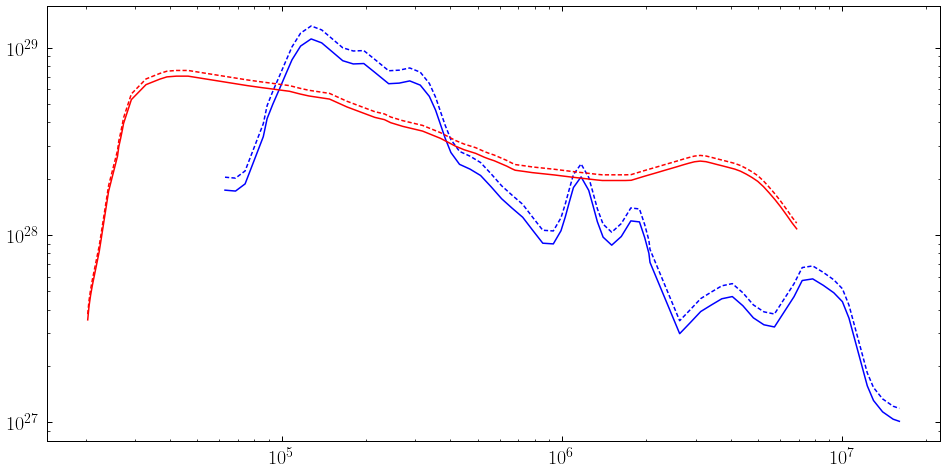

In [5]:
plt.plot(m_calore, tau_calore, c='b')
plt.plot(m_calore, tau_calore * update_factor_calore, c='b', ls='--')

plt.plot(m_fischer, tau_fischer, c='r')
plt.plot(m_fischer, tau_fischer * update_factor_fischer, c='r', ls='--')

plt.xscale('log')
plt.yscale('log')

# Save Limits

In [7]:
limit_dict = {"mDM_eV": m_fischer,
              "tau_limit_arr_s": tau_fischer*update_factor_fischer
             }
np.save("../projected_limits/"+"Integral_Fischer.npy", limit_dict)

limit_dict = {"mDM_eV": m_calore,
              "tau_limit_arr_s": tau_calore*update_factor_calore
             }
np.save("../projected_limits/"+"Integral_Calore.npy", limit_dict)



##################################################
# TAKE STRONGEST OF LIMITS

m_f, t_f = np.asarray(m_fischer), np.asarray(tau_fischer)*update_factor_fischer
m_c, t_c = np.asarray(m_calore),  np.asarray(tau_calore)*update_factor_calore

i = np.argsort(m_f); m_f, t_f = m_f[i], t_f[i]
i = np.argsort(m_c); m_c, t_c = m_c[i], t_c[i]

m0, m1 = min(m_f.min(), m_c.min()), max(m_f.max(), m_c.max())
m = np.logspace(np.log10(m0), np.log10(m1), 600)

lf = np.interp(np.log(m), np.log(m_f), np.log(t_f), left=np.nan, right=np.nan)
lc = np.interp(np.log(m), np.log(m_c), np.log(t_c), left=np.nan, right=np.nan)

tau = np.exp(np.nanmax(np.vstack([lf, lc]), axis=0))
np.save("../projected_limits/Integral_Combined.npy", {"mDM_eV": m, "tau_limit_arr_s": tau})

/tmp/ipykernel_391529/3798625713.py:24: RuntimeWarning: All-NaN slice encountered
  tau = np.exp(np.nanmax(np.vstack([lf, lc]), axis=0))


# Estimate Backgrounds

In [38]:
# just use SPI data, need to add JEMX and IBIS

# flux
flux_arr = np.loadtxt('data/Integral/SBI_flux_Calore.csv', delimiter=',')
E = flux_arr[:,0] * 1e3 # keV
flux = flux_arr[:,1] # cts/cm^2/s/keV
exposure_original = 68.5e6 # s
exposure_final = exposure_original * (16 + 6) / 16 # original was 2003-2019
effective_area = 500 # cm^2

cts_func = interp1d(E, flux * exposure_final * effective_area)

# resolution
resolution_arr = np.loadtxt('data/Integral/SBI_resolution.csv', delimiter=',')
E_res = resolution_arr[:,0] # keV
FWHM = resolution_arr[:,1] # keV

res_func = interp1d(E_res, FWHM, bounds_error=False, fill_value='extrapolate')

background_cts = lambda E: cts_func(E) * res_func(E)

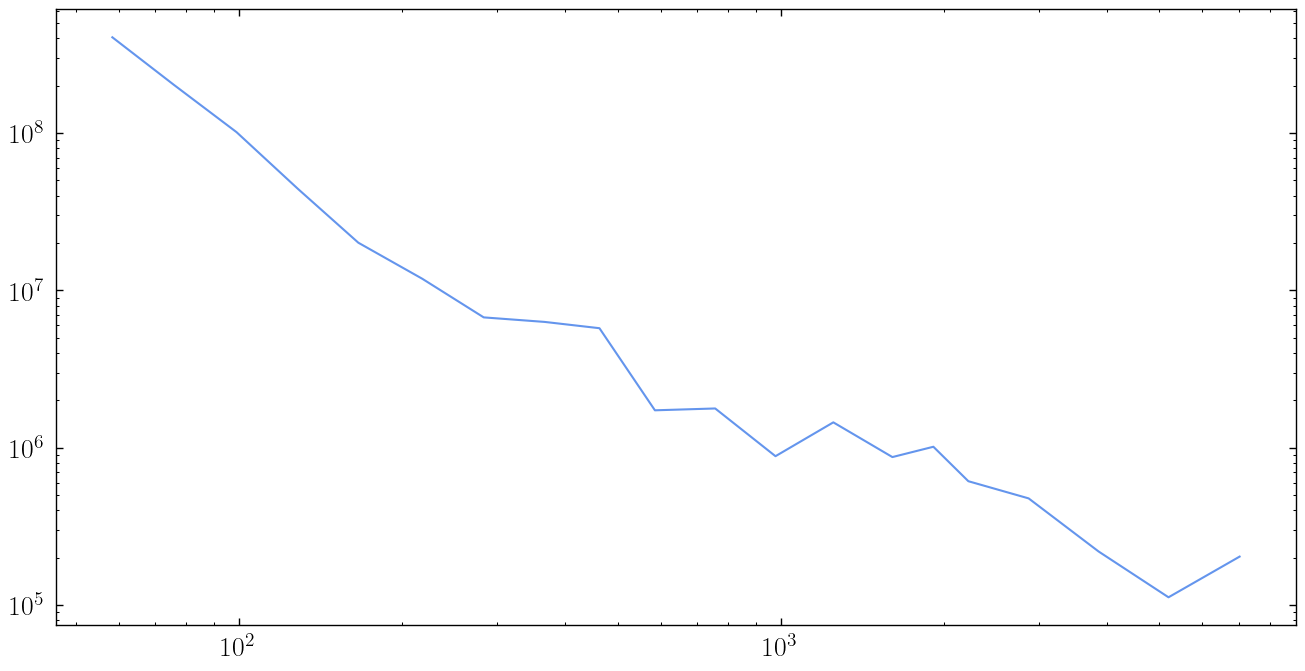

In [39]:
plt.plot(E, background_cts(E)) # cts
plt.xscale('log')
plt.yscale('log')

# Set up signal flux

In [55]:
D_map = np.load('data/D_factor_map.npz')
D_map = D_map['D_map'] # keV / cm^2

def signal_flux(m, tau):
    return 1. / (4 * np.pi * m * tau) * D_map # cts/cm^2/s/sr assuming m, D_map are in keV

def signal_flux_integrated(m, tau):
    """
    Full-sky angular integral of signal flux
    Returns: total flux in cts/cm^2/s
    """
    nside = 256
    flux_map = signal_flux(m, tau)  # cts/cm^2/s/sr
    
    # Get solid angle per pixel
    pixel_area = hp.nside2pixarea(nside)  # in steradians
    
    # Integrate over full sky
    total_flux = np.sum(flux_map * pixel_area)  # cts/cm^2/s
    
    return total_flux

def signal_cts(m, tau):
    return signal_flux_integrated(m, tau) * exposure_final * effective_area

In [56]:
for Eval in np.logspace(np.log10(E[0]*2), np.log10(E[-1]*1.9)):
    print(signal_cts(Eval, 1e32) / np.sqrt(background_cts(Eval / 2)))

3.086777247304706
3.0741193426011724
3.1723652590569675
3.3497795155083647
3.3551382708440225
3.4977587480702494
3.6474495873282535
3.758691968319192
4.143364946960298
4.2690917725734785
4.454855481463149
4.848441516205072
4.738858363735378
4.746120317497031
4.794378142324584
4.746821532471247
4.857488461812199
4.663658280422888
4.284692146282547
3.945188158045268
3.6418430718815773
3.3730208877286376
3.3538945448869137
3.722594905711129
4.6401156911645725
4.190209085904796
3.785543119699898
3.5794336607861106
3.623025784096264
3.885875862374965
3.3312296118092477
2.7453846971066844
2.3880719079755637
2.345856634526735
2.3864962755410493
2.1909530055751563
1.9059758486932656
1.958595721864308
2.0401907756576234
1.9278635573520757
1.8495281379799067
1.8002560032962438
1.8045555620842189
1.9213369659162949
1.9626607159752145
1.9375151558063046
2.008453306910905
1.8628517400358104
1.536857710228246
1.2689493775653085


# Compute and Plot Projections

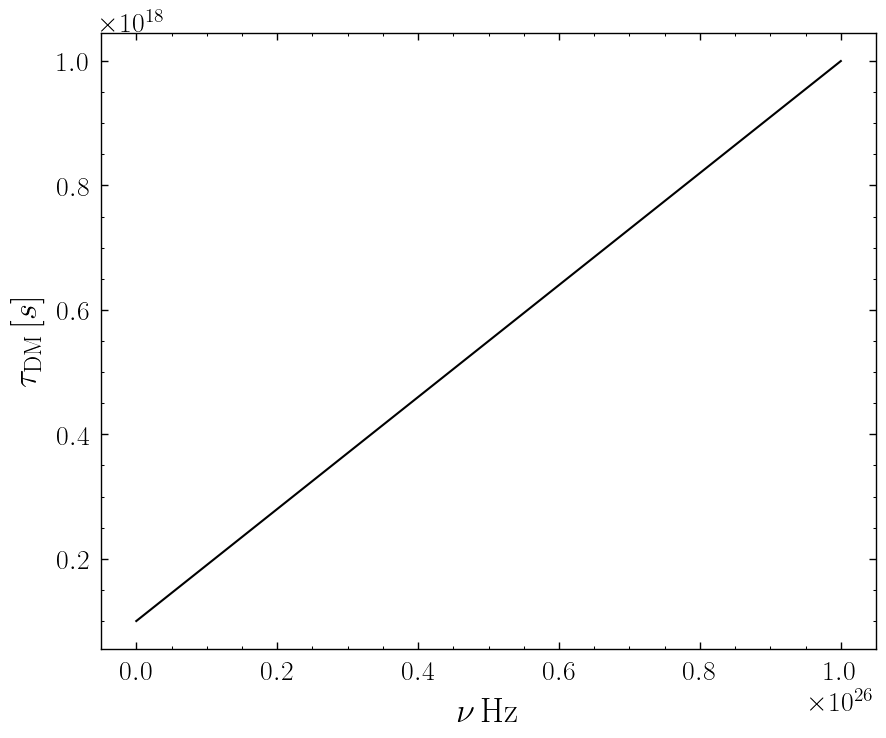

In [4]:
plt.figure(figsize=(10,8))

# placeholders!
nu_arr_Hz  = np.linspace(1e13,1e26 ,100)
tau_limit_arr = np.linspace(1e17,1e18,100)

plt.plot(nu_arr_Hz, tau_limit_arr, color="k")
plt.ylabel(r"$\tau_\mathrm{DM} \, [s]$")
plt.xlabel(r"$\nu\, \mathrm{Hz}$")
# plt.savefig("plots/mega_plot.pdf",bbox_inches="tight")